In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import chi2_contingency
import scikit_posthocs as sp
from statannotations.Annotator import Annotator
from imblearn.over_sampling import RandomOverSampler

In [2]:
# import the two datasets and then merge them to one dataframe (based on the same patient id)
df_base = pd.read_csv('baseline.csv')
df_proce = pd.read_csv('procedure.csv')
df = pd.merge(df_base, df_proce, on="PATIENTID")
print(df.shape)
df.head()

(325, 20)


,PATIENTID,site,age,bmi,CUPE,location,spesi,rvlv_rat,biomarkers,dyspnea,lytics_contra,hx_pe,hx_dvt,cur_dvt,proc_time,cath_time,fluoro_time,T20,Disks,missing
0,watwnk53tw,5,65.051335,36.54,Submassive (Intermediate Risk),saddle,2.0,1.300000,Yes,3,No,No,No,Yes,82.0,60.0,34.55,1,0,0
1,tmijs14kit,3,66.239562,39.00,Submassive (Intermediate Risk),<undefined>,NaN,NaN,Yes,Not done,Absolute,No,No,No,80.0,33.0,26.00,0,0,1
2,sur8nd7ojz,6,62.417522,33.19,Submassive (Intermediate Risk),saddle,2.0,2.910053,Yes,<undefined>,No,Yes,No,No,99.0,89.0,20.00,0,0,1
3,1uw7qeu5gb,19,72.736482,25.96,Massive (High Risk),saddle,1.0,NaN,Yes,Not done,No,No,No,No,NaN,47.0,19.50,0,0,0
4,xq1rhscbk3,27,69.399042,41.45,Massive (High Risk),bilateral,2.0,1.864238,Yes,4,No,No,No,No,62.0,37.0,12.80,0,0,0


In [3]:
# check target variable location
df['location'].value_counts()

bilateral      157
saddle         132
unilateral      32
<undefined>      4
Name: location, dtype: int64

In [4]:
# drop undefined PE location
df = df[df['location']!= '<undefined>']
df.shape

(321, 20)

## Outliers

    draw boxplot to check outliers(Q1,median,Q3)
    found cath_time with an extreme negative outlier due to data entry error therefore drop the outlier
    leave the rest of the columns unchaged because dropping outliers may lead to information loss and bias:
        - The sample size is small and it is better to keep all data we have  
        - These outliers can capture valuable information that is part of the study and may represent an under 
        sampled part of the data. It is likely that the more sample we obtain these outliers are no longer outliers
        - Excluding extreme values solely due to their extremeness can distort the results and introduce bias by
        removing information about the variability inherent in procedure characteristics
    Later I use non-parametric method which is not sensitive to outliers 

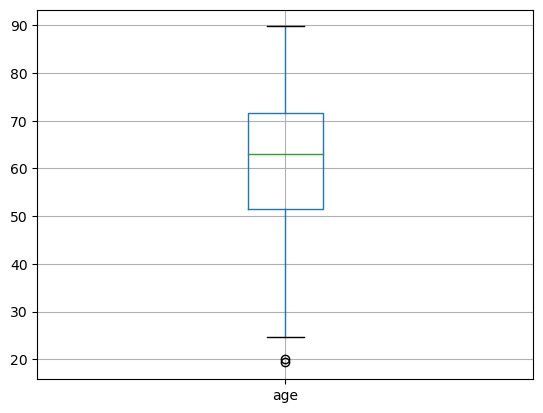

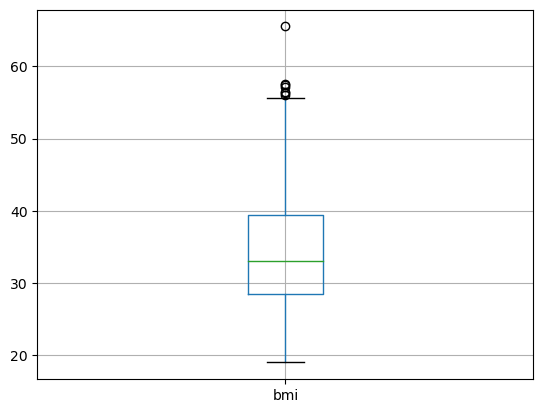

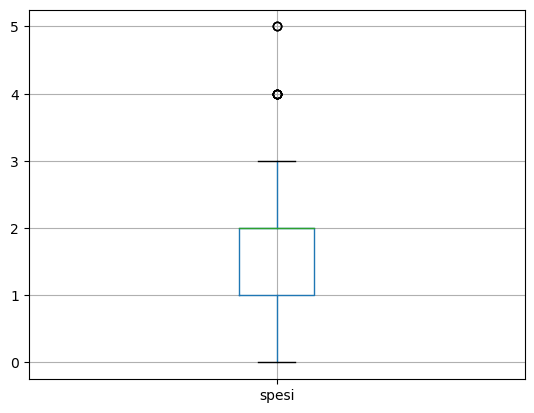

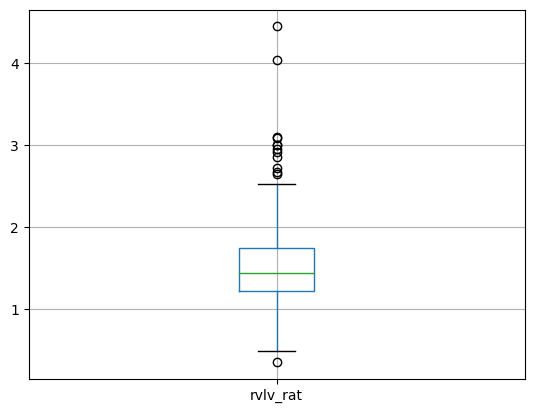

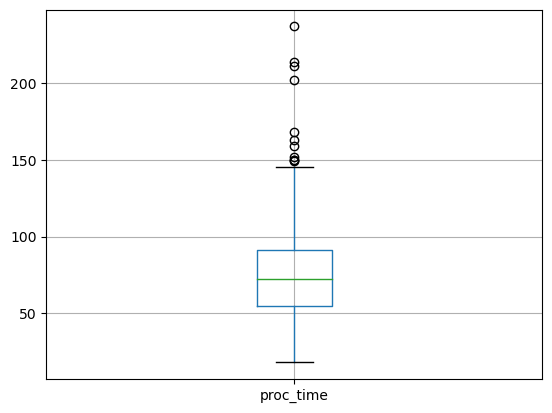

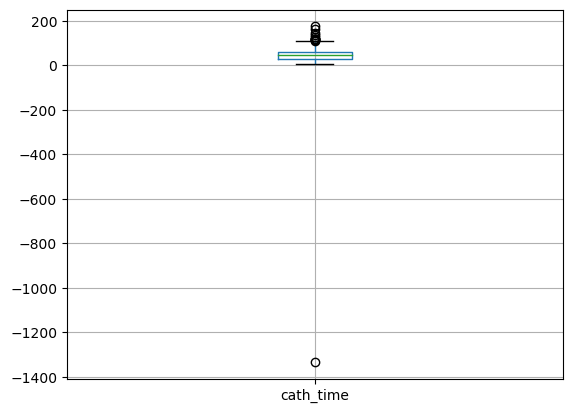

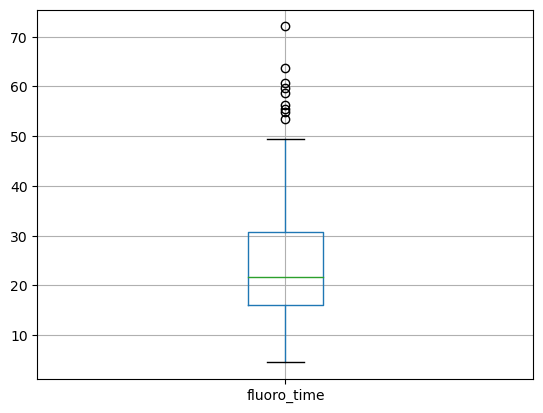

In [5]:
for column in df[['age','bmi','spesi','rvlv_rat','proc_time','cath_time','fluoro_time']]:
    plt.figure()
    df.boxplot([column])

Text(0.5, 1.0, 'Boxplot of Catheter Time')

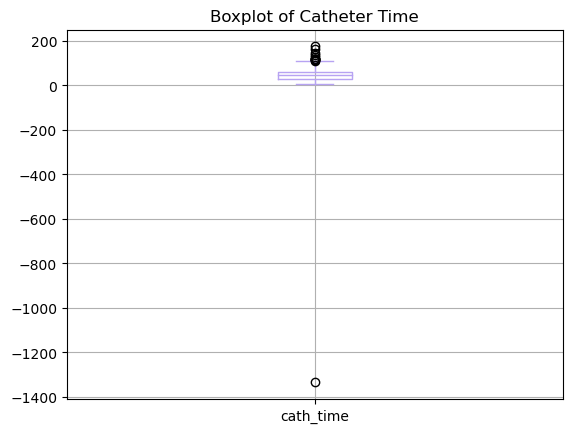

In [6]:
df.boxplot('cath_time',color='#b7a3f2')
plt.title('Boxplot of Catheter Time')

In [7]:
# cather time cannot be negative -> data entry error
# check whether there are error in proc_time and fluoro_time
# treat this as null value and fill it using linear regression to avoid information loss
df[df['cath_time']<=0]

,PATIENTID,site,age,bmi,CUPE,location,spesi,rvlv_rat,biomarkers,dyspnea,lytics_contra,hx_pe,hx_dvt,cur_dvt,proc_time,cath_time,fluoro_time,T20,Disks,missing
40,45jjzsnhbg,19,42.934976,26.31,Submassive (Intermediate Risk),bilateral,NaN,NaN,<undefined>,<undefined>,<undefined>,No,No,<undefined>,105.0,-1335.0,31.3,1,0,0


In [8]:
df_drop_na = df.drop(index=40,axis=0)

<AxesSubplot:>

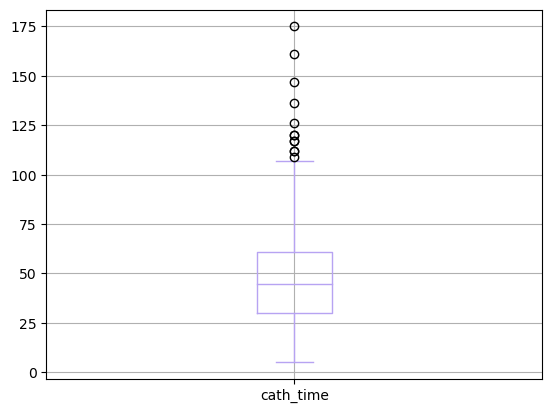

In [9]:
df_drop_na.boxplot('cath_time',color='#b7a3f2')

## Missing Value

In [10]:
# percentage of missing value in each column
df.isnull().sum() / len(df)

PATIENTID        0.000000
site             0.000000
age              0.000000
bmi              0.003115
CUPE             0.000000
location         0.000000
spesi            0.071651
rvlv_rat         0.065421
biomarkers       0.000000
dyspnea          0.000000
lytics_contra    0.000000
hx_pe            0.000000
hx_dvt           0.000000
cur_dvt          0.000000
proc_time        0.080997
cath_time        0.074766
fluoro_time      0.028037
T20              0.000000
Disks            0.000000
missing          0.000000
dtype: float64

In [11]:
# create dataframe where I drop all rows where procedure time variables have null values for comparison purpose
df_drop_na = df_drop_na.dropna(subset=['proc_time','cath_time','fluoro_time'])
df_drop_na.shape

(286, 20)

### BMI

only 1 row missing, fill it with the column median as the distribution is right-skewed

33.03


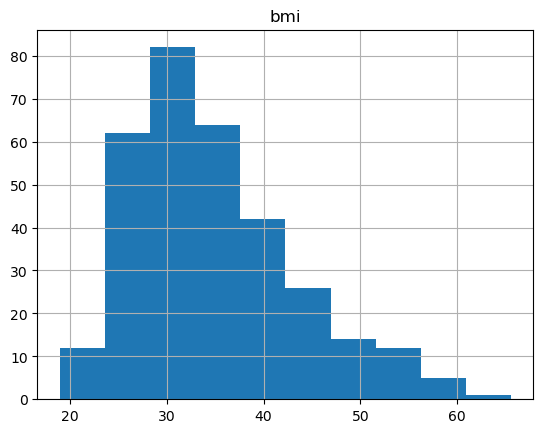

In [12]:
df.hist('bmi')
print(df['bmi'].median())

In [13]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

### SPESI

Fill null values with column median as this column is not the main focus

These rows have valuable information on procedure characterstics, which is my main focus, therefore should not drop

In future studies, the SPESI column needs more domain knowledge to determine the best method to fill null values

In [14]:
df['spesi'] = df['spesi'].fillna(df['spesi'].median())

### RVLV Ratio

array([[<AxesSubplot:title={'center':'rvlv_rat'}>]], dtype=object)

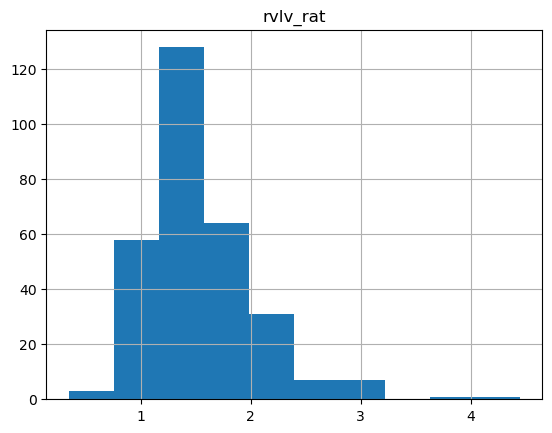

In [15]:
df.hist('rvlv_rat')

In [16]:
df['rvlv_rat'] = df['rvlv_rat'].fillna(df['rvlv_rat'].median())

### Proc_time

Text(0.5, 1.0, 'Correlation Heatmap of Time Variables')

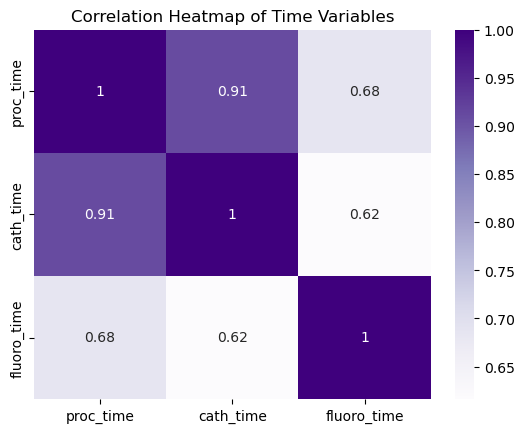

In [17]:
# the time variables are highly correlated
sns.heatmap(df[df['cath_time']>0][['proc_time','cath_time','fluoro_time']].corr(),annot=True,cmap='Purples')
plt.title('Correlation Heatmap of Time Variables')

In [18]:
# drop rows where these 3 time columns all contain missing values as there is no way to fill them all
df = df.dropna(subset=['proc_time','cath_time','fluoro_time'],how='all')

In [19]:
# can use fluoro_time to predict proc_time and cath_time
df[df['proc_time'].isnull()][['proc_time','cath_time','fluoro_time']]

,proc_time,cath_time,fluoro_time
3,NaN,47.0,19.5
5,NaN,NaN,28.8
58,NaN,NaN,63.8
62,NaN,NaN,49.5
73,NaN,NaN,25.0
83,NaN,NaN,15.6
88,NaN,NaN,15.0
92,NaN,NaN,16.0
95,NaN,NaN,16.0
99,NaN,NaN,28.0


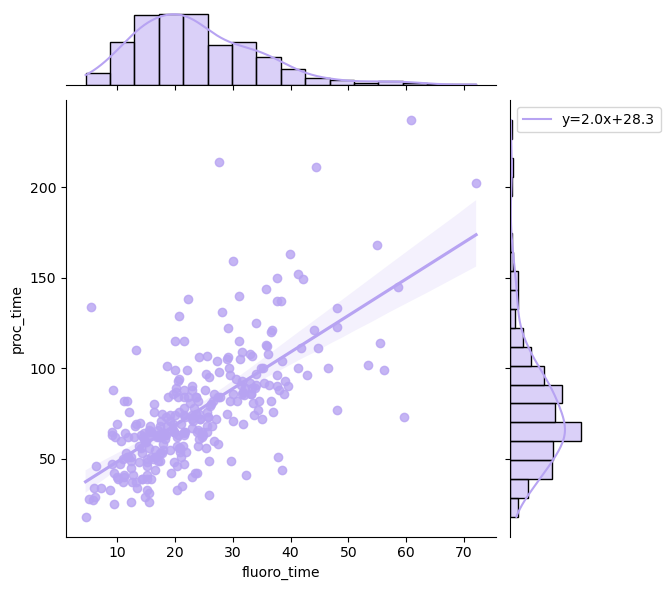

In [20]:
df1 = df.dropna(subset=['proc_time','fluoro_time'])
x,y = df1['fluoro_time'],df1['proc_time']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line_kws="y={0:.1f}x+{1:.1f}".format(slope,intercept)
g = sns.jointplot(data=df, x='fluoro_time', y='proc_time',kind='reg',color='#b7a3f2')
plt.legend(labels=[line_kws]);

In [21]:
df['proc_time']=df['proc_time'].fillna(df['fluoro_time']*2+28.3)

In [22]:
# check the value after filling na
df.iloc[[2]][['proc_time','cath_time','fluoro_time']]

,proc_time,cath_time,fluoro_time
3,67.3,47.0,19.5


### Cath_time

In [23]:
df[df['cath_time'].isnull()][['proc_time','cath_time','fluoro_time']]

,proc_time,cath_time,fluoro_time
5,85.9,NaN,28.8
52,73.0,NaN,18.5
58,155.9,NaN,63.8
62,127.3,NaN,49.5
73,78.3,NaN,25.0
83,59.5,NaN,15.6
88,58.3,NaN,15.0
92,60.3,NaN,16.0
95,60.3,NaN,16.0
99,84.3,NaN,28.0


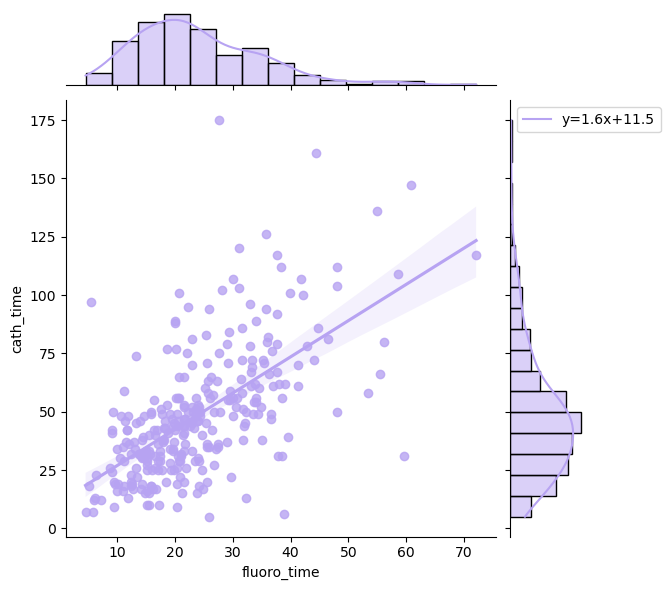

In [24]:
df2 = df[df['cath_time']>0].dropna(subset=['cath_time','fluoro_time'])
x,y = df2['fluoro_time'],df2['cath_time']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line_kws="y={0:.1f}x+{1:.1f}".format(slope,intercept)
g = sns.jointplot(data=df2, x='fluoro_time', y='cath_time',kind='reg',color='#b7a3f2')
plt.legend(labels=[line_kws]);

In [25]:
df['cath_time']=df['cath_time'].fillna(df['fluoro_time']*1.6+11.5)

In [26]:
df.iloc[[4]][['proc_time','cath_time','fluoro_time']]

,proc_time,cath_time,fluoro_time
5,85.9,57.58,28.8


In [27]:
df.iloc[39,15] = df.iloc[39,16]*1.6+11.5

In [28]:
df.iloc[39,15]

61.580000000000005

<AxesSubplot:>

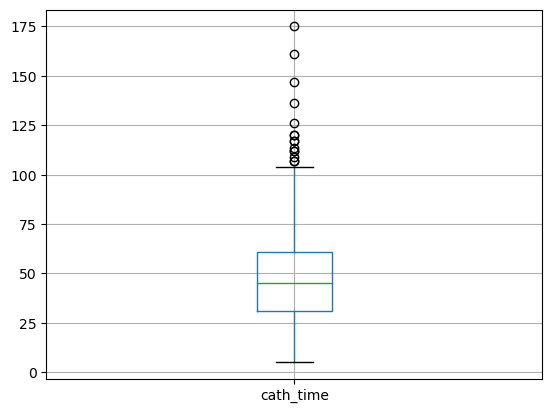

In [29]:
df.boxplot('cath_time')

### Fluoro_time

In [30]:
df[df['fluoro_time'].isnull()][['proc_time','cath_time','fluoro_time']]

,proc_time,cath_time,fluoro_time
38,51.0,36.0,NaN
44,70.0,39.0,NaN
47,150.0,120.0,NaN
48,104.0,52.0,NaN
96,89.0,75.0,NaN
138,52.0,29.0,NaN
301,92.0,71.0,NaN


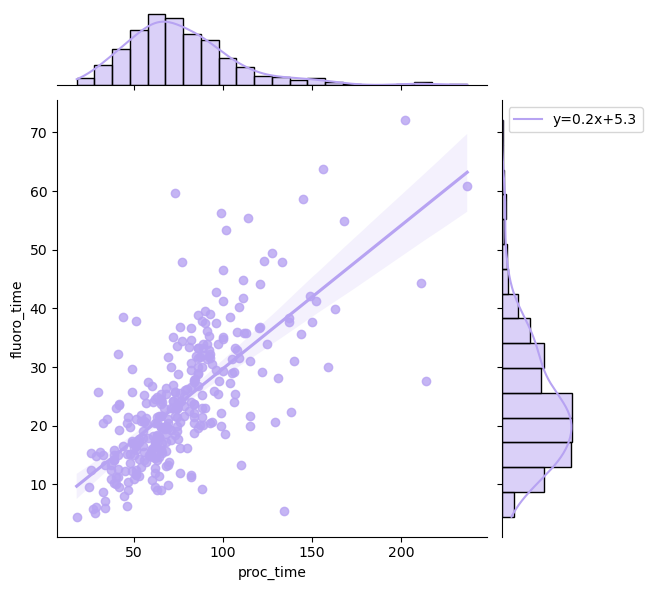

In [31]:
df3 = df.dropna(subset=['proc_time','fluoro_time'])
x,y = df3['proc_time'],df3['fluoro_time']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line_kws="y={0:.1f}x+{1:.1f}".format(slope,intercept)
g = sns.jointplot(data=df, x='proc_time', y='fluoro_time',kind='reg',color='#b7a3f2')
plt.legend(labels=[line_kws]);

In [32]:
df['fluoro_time']=df['fluoro_time'].fillna(df['proc_time']*0.2+5.3)

In [33]:
df.iloc[[37]][['proc_time','cath_time','fluoro_time']]

,proc_time,cath_time,fluoro_time
38,51.0,36.0,15.5


In [34]:
# check for remaining null values
df.isnull().sum() / len(df)

PATIENTID        0.0
site             0.0
age              0.0
bmi              0.0
CUPE             0.0
location         0.0
spesi            0.0
rvlv_rat         0.0
biomarkers       0.0
dyspnea          0.0
lytics_contra    0.0
hx_pe            0.0
hx_dvt           0.0
cur_dvt          0.0
proc_time        0.0
cath_time        0.0
fluoro_time      0.0
T20              0.0
Disks            0.0
missing          0.0
dtype: float64

***

In [35]:
df.shape

(319, 20)

In [36]:
df.describe()

,site,age,bmi,spesi,rvlv_rat,proc_time,cath_time,fluoro_time,T20,Disks,missing
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,10.821317,61.138946,34.720690,1.614420,1.539288,77.006897,49.165705,24.041536,0.435737,0.100313,0.385580
std,8.866376,14.106528,8.493024,1.002471,0.490006,32.080392,27.451407,11.077147,0.496632,0.300890,0.487497
min,1.000000,19.307324,19.000000,0.000000,0.346154,18.000000,5.000000,4.500000,0.000000,0.000000,0.000000
25%,5.000000,51.490760,28.525000,1.000000,1.235294,56.000000,31.000000,15.900000,0.000000,0.000000,0.000000
50%,7.000000,63.030801,33.030000,2.000000,1.438999,72.000000,45.000000,21.730000,0.000000,0.000000,0.000000
75%,15.000000,71.305955,39.420000,2.000000,1.719212,91.000000,61.000000,30.300000,1.000000,0.000000,1.000000
max,42.000000,89.793292,65.530000,5.000000,4.448000,237.000000,175.000000,72.100000,1.000000,1.000000,1.000000


<AxesSubplot:>

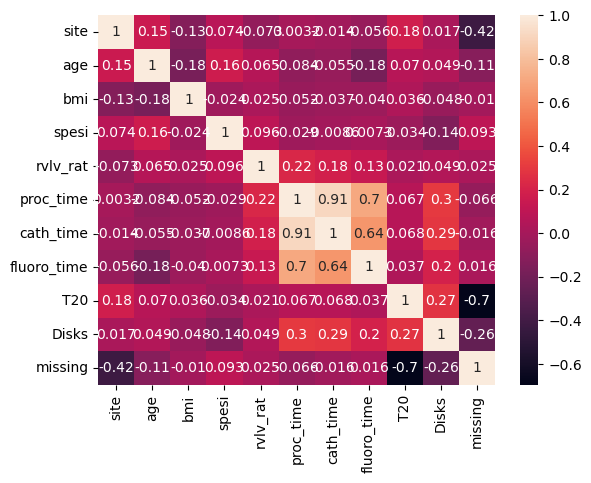

In [37]:
sns.heatmap(df.corr(),annot=True)

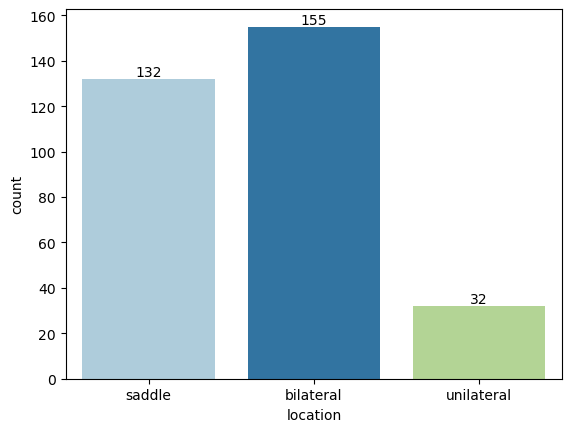

In [38]:
# the location column is imbalance
ax = sns.countplot(data = df, x ='location',palette = "Paired")
ax.bar_label(ax.containers[0]);

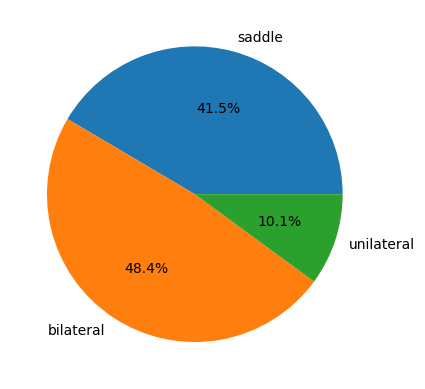

In [39]:
fig, ax = plt.subplots()
ax.pie((132,154,32), labels=('saddle', 'bilateral', 'unilateral'), autopct='%1.1f%%')
plt.show()

## Loaction & Procedure Time Variables Analysis

Question: Is the procedure time, catheter time, and fluoroscoopy time statistically different between the 3 PE locations? 

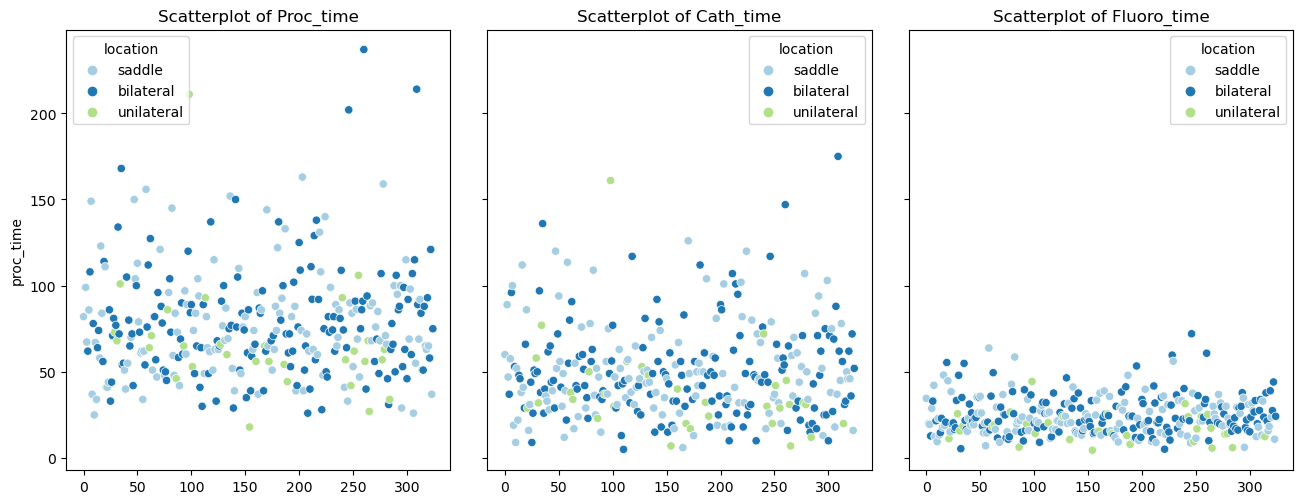

In [40]:
# could not figure out an underlying pattern solely looking at scatterplot
fig, ax =plt.subplots(1,3,figsize=(13,5),sharey=True)
plt.tight_layout()
sns.scatterplot(data=df, x=df.index, y='proc_time',hue='location',ax=ax[0],palette = "Paired").set(title='Scatterplot of Proc_time')
sns.scatterplot(data=df, x=df.index, y='cath_time',hue='location',ax=ax[1],palette = "Paired").set(title='Scatterplot of Cath_time')
sns.scatterplot(data=df, x=df.index, y='fluoro_time',hue='location',ax=ax[2],palette = "Paired",hue_order =['saddle','bilateral','unilateral']).set(title='Scatterplot of Fluoro_time');

## Kruskal-Wallis Hypothesis Test

    a nonparametric method for testing whether samples are originated from the same distribution
    does not assume a normal distribution of the underlying data
    allows to compare 3 or more groups
    
    The null hypothesis (H0): The 3 PE locations are not different in terms of procedure characteristics
    The alternative hypothesis: (Ha): At least 1 location is different from the other 2 locations in terms of procedure characteristics
    P-value: The probability of Null hypothesis being true
    
    Often used in healthcare industry because data has outliers and a non-normal distribution

Calculation behine the scene: 
    
    alpha level = 0.05 
    degrees of freedom = k-1 = 3-1 = 2
    refer to chi-square table and critical value: 5.99147
    decision rule: if chi-square > 5.9914, reject null hypothesis
    calculate test statistics: rank all the data from smallest to largest where small number has low rank and large number has high rank. If several values are the same, calculate the mean rank. Then transform the data to ranks then and function to calculate H value. Compare the H value with the critical value
        

### Test on original data without filling null values
286 patients

In [41]:
df_drop_na.shape

(286, 20)

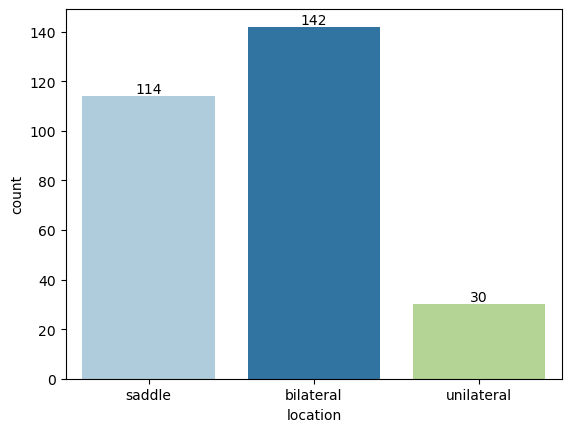

In [42]:
ax = sns.countplot(data = df_drop_na, x ='location',palette = "Paired")
ax.bar_label(ax.containers[0]);

#### Distribution Check

    found the distribution right skewed and non-normal

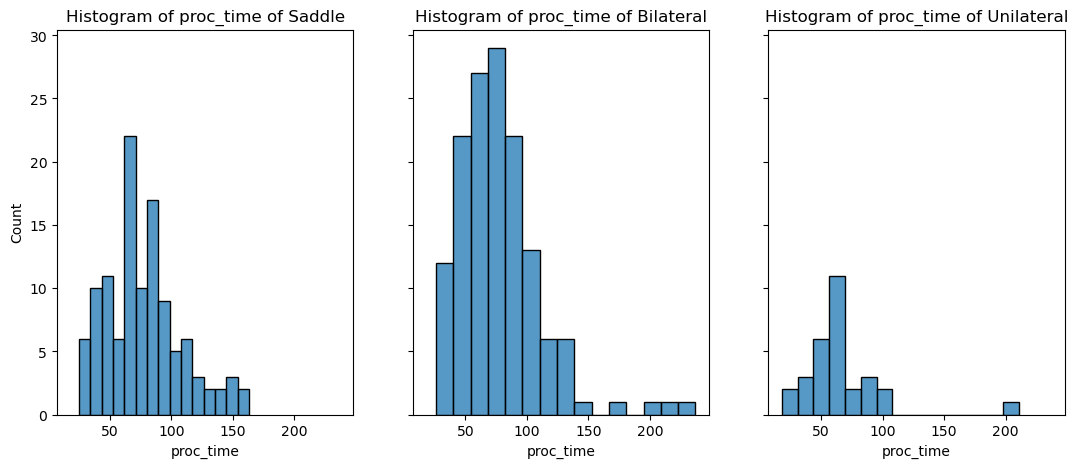

In [43]:
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True,sharex=True)
sns.histplot(df_drop_na[df_drop_na['location']=='saddle']['proc_time'],bins=15,ax=axes[0])
axes[0].set_title('Histogram of proc_time of Saddle')

sns.histplot(df_drop_na[df_drop_na['location']=='bilateral']['proc_time'],bins=15,ax=axes[1])
axes[1].set_title('Histogram of proc_time of Bilateral')

sns.histplot(df_drop_na[df_drop_na['location']=='unilateral']['proc_time'],bins=15,ax=axes[2])
axes[2].set_title('Histogram of proc_time of Unilateral');

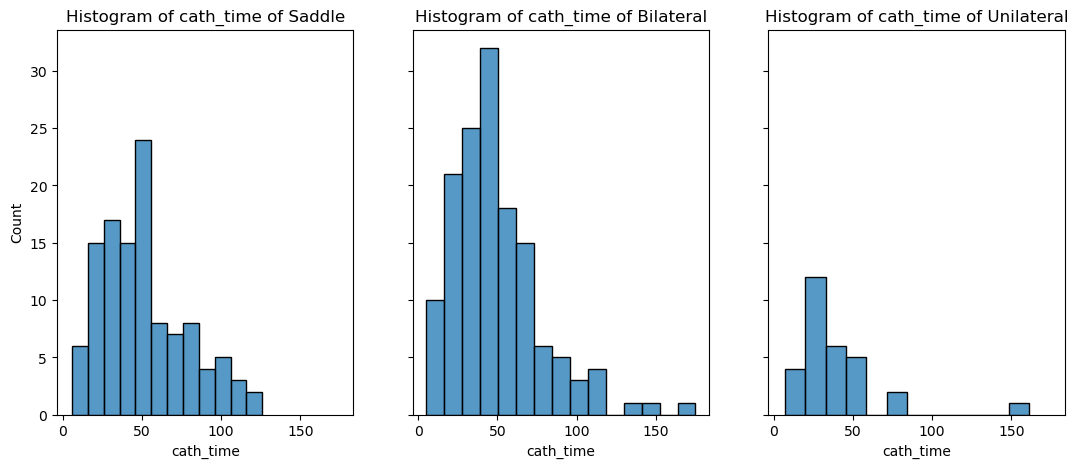

In [44]:
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True,sharex=True)
sns.histplot(df_drop_na[df_drop_na['location']=='saddle']['cath_time'],bins=12,ax=axes[0])
axes[0].set_title('Histogram of cath_time of Saddle')

sns.histplot(df_drop_na[df_drop_na['location']=='bilateral']['cath_time'],bins=15,ax=axes[1])
axes[1].set_title('Histogram of cath_time of Bilateral')

sns.histplot(df_drop_na[df_drop_na['location']=='unilateral']['cath_time'],bins=12,ax=axes[2])
axes[2].set_title('Histogram of cath_time of Unilateral');

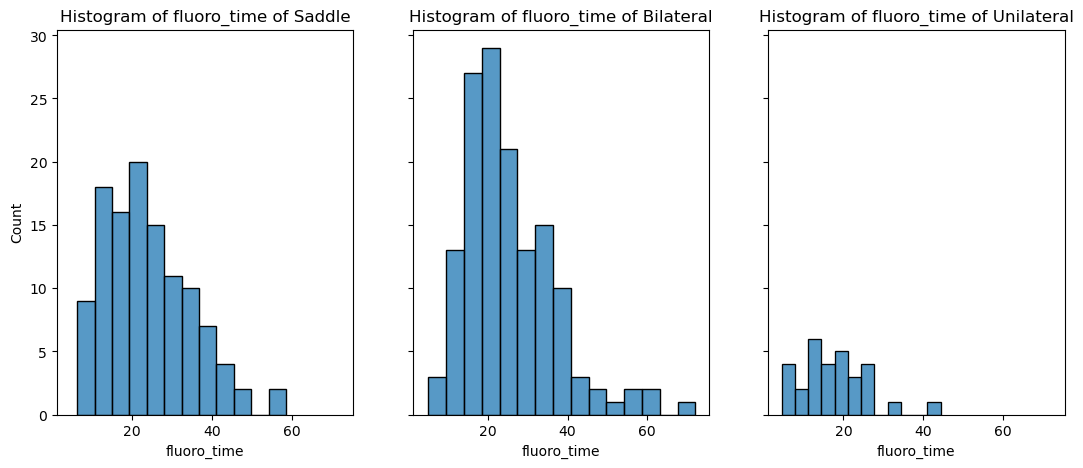

In [45]:
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True,sharex=True)
sns.histplot(df_drop_na[df_drop_na['location']=='saddle']['fluoro_time'],bins=12,ax=axes[0])
axes[0].set_title('Histogram of fluoro_time of Saddle')

sns.histplot(df_drop_na[df_drop_na['location']=='bilateral']['fluoro_time'],bins=15,ax=axes[1])
axes[1].set_title('Histogram of fluoro_time of Bilateral')

sns.histplot(df_drop_na[df_drop_na['location']=='unilateral']['fluoro_time'],bins=12,ax=axes[2])
axes[2].set_title('Histogram of fluoro_time of Unilateral');

#### Shapiro-Wilk Test on Normality Assumption:

    great for small sample size
    most powerful and most common

In [46]:
# Normality Assumption Check Fails -> use non-parametric test
for i in ['proc_time','cath_time','fluoro_time']:
    print(stats.shapiro(df_drop_na[i])) 

ShapiroResult(statistic=0.9093023538589478, pvalue=4.070447971737945e-12)
ShapiroResult(statistic=0.9178319573402405, pvalue=1.990999205780941e-11)
ShapiroResult(statistic=0.9424439668655396, pvalue=3.9401815143946806e-09)


#### Levene's Test of Homogeneity of Variances Assumption: 

    determine whether two or more groups have equal variances
    more robust against violations of the normality assumption
    
    Null hypothesis: all the groups have same variances
    Alternative hypothesis: At least one pair of groups have different variances
    
    use center = 'median' because we have right-skewed distribution
    
    It is not a required assumption for kruskal-Wallis test unless hypothesis includes comparing the median

In [47]:
# homoscedasticity assumption holds
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_drop_na[df_drop_na['location']=='saddle'][i]
    group2 = df_drop_na[df_drop_na['location']=='unilateral'][i]
    group3 = df_drop_na[df_drop_na['location']=='bilateral'][i]
    print(stats.levene(group1, group2, group3, center='median'))
# all p-values > 0.05 -> fail to reject null -> all groups have equal variances

LeveneResult(statistic=0.5300530508332676, pvalue=0.5891569012759899)
LeveneResult(statistic=0.5390777271247149, pvalue=0.5838837024064858)
LeveneResult(statistic=1.0318369869014474, pvalue=0.35768841169403237)


In [48]:
# kruskal wallis test
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_drop_na[df_drop_na['location']=='saddle'][i]
    group2 = df_drop_na[df_drop_na['location']=='unilateral'][i]
    group3 = df_drop_na[df_drop_na['location']=='bilateral'][i]
    print(stats.kruskal(group1,group2,group3))
# since p-value for cath_time and fluoro time < 0.05, we can reject null hypothesis
# conclude the PE location leads to statistically significant difference in cath_time, fluoro time

KruskalResult(statistic=4.790564651672562, pvalue=0.09114694215302349)
KruskalResult(statistic=6.095491618816144, pvalue=0.04746580084764202)
KruskalResult(statistic=11.583025435018765, pvalue=0.003053359810290194)


#### Pairwise Comparison - Post-hoc Tests

The outcome of the Kruskal–Wallis test tells you if there are differences among the groups, but doesn’t tell you which groups are different from other groups.  In order to determine which groups are different from others, post-hoc testing should be conducted 

The most common post-hoc test for the Kruskal–Wallis test is the Dunn's test

Dunn’s Test performs pairwise comparisons between each independent group (allows groups to have different size) and tells you which groups are statistically significantly different

It uses the absolute value of the difference between the mean rank of each group to infer difference of mean rankings in each group.

Calculation: calcualte z score using absolute value of the difference between the mean rank of each group divided by the standard error. If there are many ties, the standard error includes a ties correction. Compare the z value with z critical value(1.96 when alpha=0.05)

Whenever we make multiple comparisons at once, it’s important that we control the family-wise error rate. Because the post-hoc test will produce multiple p-values, adjustments to the p-values can be made to avoid inflating the possibility of making a type-I error. Here I use the Bonferroni Adjustment

In [49]:
group1 = df_drop_na[df_drop_na['location']=='saddle']['cath_time']
group2 = df_drop_na[df_drop_na['location']=='unilateral']['cath_time']
group3 = df_drop_na[df_drop_na['location']=='bilateral']['cath_time']
data = [group1, group2, group3]
df_drop_na_ph_c = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
df_drop_na_ph_c = df_drop_na_ph_c.rename(columns ={1:'saddle',2:'unilateral',3:'bilateral'},
                         index={1:'saddle',2:'unilateral',3:'bilateral'})
df_drop_na_ph_c
# saddle and unilateral location significantly differs in fluoro time
# bilateral and unilateral location significantly differs in fluoro time

,saddle,unilateral,bilateral
saddle,1.000000,0.044133,1.000000
unilateral,0.044133,1.000000,0.084266
bilateral,1.000000,0.084266,1.000000


In [50]:
for i in ['saddle','unilateral','bilateral']:
    print(i,df_drop_na[df_drop_na['location']==i]['cath_time'].median())

saddle 46.0
unilateral 32.0
bilateral 44.0


In [51]:
df_drop_na_ph_c = df_drop_na_ph_c.melt(ignore_index=False).reset_index()
df_drop_na_ph_c = df_drop_na_ph_c[df_drop_na_ph_c['value']!=1]
df_drop_na_ph_c = df_drop_na_ph_c.drop_duplicates(subset='value')
df_drop_na_ph_c

,index,variable,value
1,unilateral,saddle,0.044133
5,bilateral,unilateral,0.084266


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bilateral vs. unilateral: Custom statistical test, P_val:8.427e-02
saddle vs. unilateral: Custom statistical test, P_val:4.413e-02


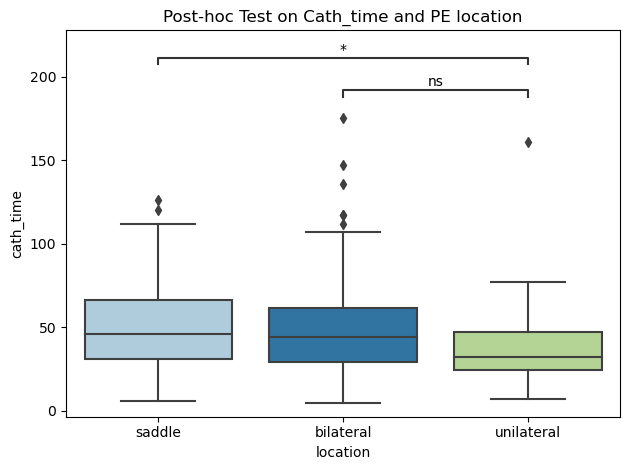

In [52]:
ax = sns.boxplot(data=df_drop_na, x="location", y="cath_time",order=['saddle','bilateral','unilateral'],palette = "Paired")

pairs = [(i[1]["index"], i[1]["variable"]) for i in df_drop_na_ph_c.iterrows()]
p_values = [i[1]["value"] for i in df_drop_na_ph_c.iterrows()]

annotator = Annotator(
    ax, pairs, data=df_drop_na, x="location", y='cath_time', order=['saddle','bilateral','unilateral']
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)
plt.title('Post-hoc Test on Cath_time and PE location')
plt.tight_layout()

In [53]:
group1 = df_drop_na[df_drop_na['location']=='saddle']['fluoro_time']
group2 = df_drop_na[df_drop_na['location']=='unilateral']['fluoro_time']
group3 = df_drop_na[df_drop_na['location']=='bilateral']['fluoro_time']
data = [group1, group2, group3]
df_drop_na_ph_f = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
df_drop_na_ph_f = df_drop_na_ph_f.rename(columns ={1:'saddle',2:'unilateral',3:'bilateral'},
                         index={1:'saddle',2:'unilateral',3:'bilateral'})
df_drop_na_ph_f
# saddle and unilateral location significantly differs in fluoro time
# bilateral and unilateral location significantly differs in fluoro time

,saddle,unilateral,bilateral
saddle,1.000000,0.015428,1.000000
unilateral,0.015428,1.000000,0.002004
bilateral,1.000000,0.002004,1.000000


In [54]:
for i in ['saddle','unilateral','bilateral']:
    print(i,df_drop_na[df_drop_na['location']==i]['fluoro_time'].median())

saddle 21.665
unilateral 17.1
bilateral 22.450000000000003


In [55]:
df_drop_na_ph_f = df_drop_na_ph_f.melt(ignore_index=False).reset_index()
df_drop_na_ph_f = df_drop_na_ph_f[df_drop_na_ph_f['value']!=1]
df_drop_na_ph_f = df_drop_na_ph_f.drop_duplicates(subset='value')
df_drop_na_ph_f

,index,variable,value
1,unilateral,saddle,0.015428
5,bilateral,unilateral,0.002004


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bilateral vs. unilateral: Custom statistical test, P_val:2.004e-03
saddle vs. unilateral: Custom statistical test, P_val:1.543e-02


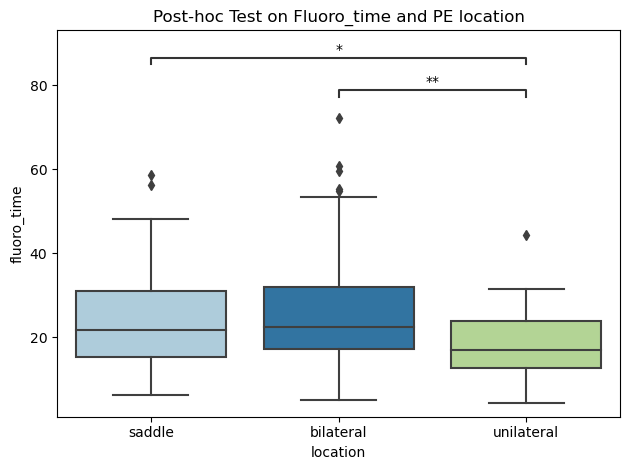

In [56]:
ax = sns.boxplot(data=df_drop_na, x="location", y="fluoro_time",palette = "Paired",order=['saddle','bilateral','unilateral'])

pairs = [(i[1]["index"], i[1]["variable"]) for i in df_drop_na_ph_f.iterrows()]
p_values = [i[1]["value"] for i in df_drop_na_ph_f.iterrows()]

annotator = Annotator(
    ax, pairs, data=df_drop_na, x="location", y='fluoro_time', order=['saddle','bilateral','unilateral']
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)
plt.title('Post-hoc Test on Fluoro_time and PE location')
plt.tight_layout()

### Test on data after filling null values with linear regression
319 patients

In [57]:
df.shape

(319, 20)

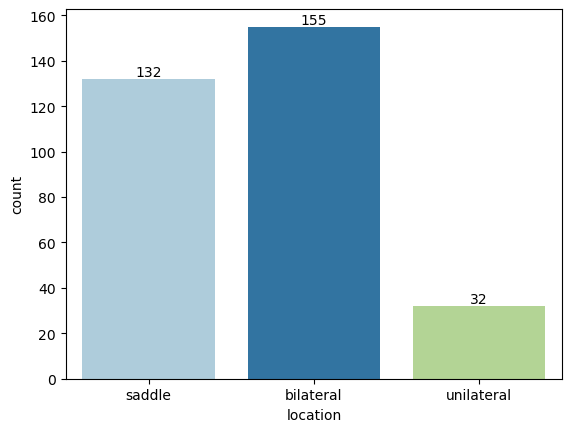

In [58]:
ax = sns.countplot(data = df, x ='location',palette = "Paired")
ax.bar_label(ax.containers[0]);

In [59]:
# Normality Assumption Check fails
for i in ['proc_time','cath_time','fluoro_time']:
    print(stats.shapiro(df[i])) 

ShapiroResult(statistic=0.9122998118400574, pvalue=1.102705166761142e-12)
ShapiroResult(statistic=0.9196511507034302, pvalue=4.722011410357441e-12)
ShapiroResult(statistic=0.9382449984550476, pvalue=2.9127136813578147e-10)


In [60]:
# homoscedasticity assumption holds
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df[df['location']=='saddle'][i]
    group2 = df[df['location']=='unilateral'][i]
    group3 = df[df['location']=='bilateral'][i]
    print(stats.levene(group1, group2, group3, center='median'))
# all p-values > 0.05 -> fail to reject null -> all groups have equal variances

LeveneResult(statistic=0.5453068159870091, pvalue=0.5802083798314093)
LeveneResult(statistic=0.6582427210480755, pvalue=0.5184688308687257)
LeveneResult(statistic=0.956874775064732, pvalue=0.3852014161045816)


In [61]:
# kruskal wallis test
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df[df['location']=='saddle'][i]
    group2 = df[df['location']=='unilateral'][i]
    group3 = df[df['location']=='bilateral'][i]
    print(stats.kruskal(group1,group2,group3))
# p-value of proc_time, cath time, and fluoro_time are all below 0.05 -> reject null hypothesis

KruskalResult(statistic=7.399827336623036, pvalue=0.024725660986261663)
KruskalResult(statistic=8.849470668893668, pvalue=0.011977380881482189)
KruskalResult(statistic=15.421366413818717, pvalue=0.00044801528541144595)


In [62]:
# post-hoc test on proc_time
group1 = df[df['location']=='saddle']['proc_time']
group2 = df[df['location']=='unilateral']['proc_time']
group3 = df[df['location']=='bilateral']['proc_time']
data = [group1, group2, group3]
df_ph_p = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
df_ph_p = df_ph_p.rename(columns ={1:'saddle',2:'unilateral',3:'bilateral'},
                         index={1:'saddle',2:'unilateral',3:'bilateral'})
df_ph_p
# saddle and unilateral location significantly differs in proc time
# bilateral and unilateral location significantly differs in proc time

,saddle,unilateral,bilateral
saddle,1.000000,0.037053,1.000000
unilateral,0.037053,1.000000,0.023471
bilateral,1.000000,0.023471,1.000000


In [63]:
for i in ['saddle','unilateral','bilateral']:
    print(i,df[df['location']==i]['proc_time'].median())

saddle 72.5
unilateral 61.0
bilateral 74.3


In [64]:
df_ph_p= df_ph_p.melt(ignore_index=False).reset_index()
df_ph_p = df_ph_p[df_ph_p['value']!=1]
df_ph_p = df_ph_p.drop_duplicates(subset='value')
df_ph_p

,index,variable,value
1,unilateral,saddle,0.037053
5,bilateral,unilateral,0.023471


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bilateral vs. unilateral: Custom statistical test, P_val:2.347e-02
saddle vs. unilateral: Custom statistical test, P_val:3.705e-02


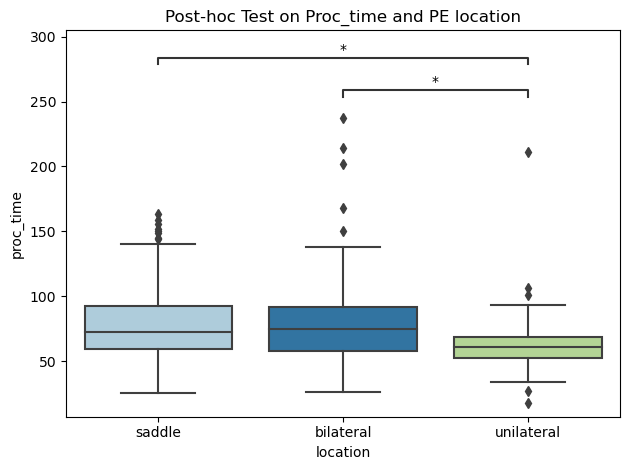

In [65]:
ax = sns.boxplot(data=df, x="location", y="proc_time",order=['saddle','bilateral','unilateral'],palette = "Paired")

pairs = [(i[1]["index"], i[1]["variable"]) for i in df_ph_p.iterrows()]
p_values = [i[1]["value"] for i in df_ph_p.iterrows()]

annotator = Annotator(
    ax, pairs, data=df, x="location", y='proc_time', order=['saddle','bilateral','unilateral']
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)
plt.title('Post-hoc Test on Proc_time and PE location')
plt.tight_layout()

In [66]:
# post-hoc test on cath_time
group1 = df[df['location']=='saddle']['cath_time']
group2 = df[df['location']=='unilateral']['cath_time']
group3 = df[df['location']=='bilateral']['cath_time']
data = [group1, group2, group3]
df_ph_c = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
df_ph_c = df_ph_c.rename(columns ={1:'saddle',2:'unilateral',3:'bilateral'},
                         index={1:'saddle',2:'unilateral',3:'bilateral'})
df_ph_c
# saddle and unilateral location significantly differs in cath time
# bilateral and unilateral location significantly differs in cath time

,saddle,unilateral,bilateral
saddle,1.000000,0.010415,1.000000
unilateral,0.010415,1.000000,0.020345
bilateral,1.000000,0.020345,1.000000


In [67]:
for i in ['saddle','unilateral','bilateral']:
    print(i,df[df['location']==i]['cath_time'].median())

saddle 46.0
unilateral 32.0
bilateral 46.0


In [68]:
df_ph_c= df_ph_c.melt(ignore_index=False).reset_index()
df_ph_c = df_ph_c[df_ph_c['value']!=1]
df_ph_c = df_ph_c.drop_duplicates(subset='value')
df_ph_c

,index,variable,value
1,unilateral,saddle,0.010415
5,bilateral,unilateral,0.020345


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bilateral vs. unilateral: Custom statistical test, P_val:2.034e-02
saddle vs. unilateral: Custom statistical test, P_val:1.042e-02


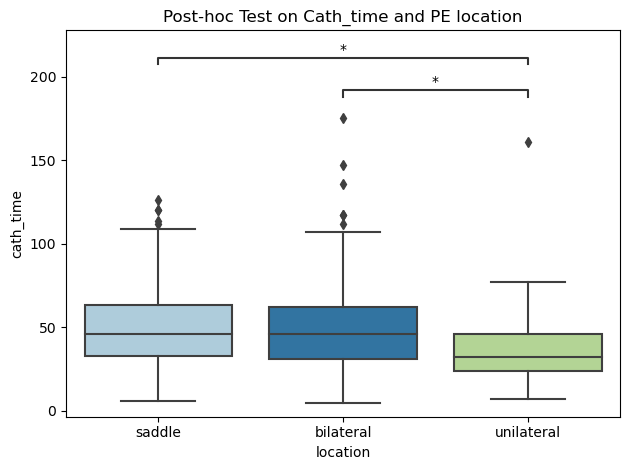

In [69]:
ax = sns.boxplot(data=df, x="location", y="cath_time",order=['saddle','bilateral','unilateral'],palette = "Paired")

pairs = [(i[1]["index"], i[1]["variable"]) for i in df_ph_c.iterrows()]
p_values = [i[1]["value"] for i in df_ph_c.iterrows()]

annotator = Annotator(
    ax, pairs, data=df, x="location", y='cath_time', order=['saddle','bilateral','unilateral']
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)
plt.title('Post-hoc Test on Cath_time and PE location')
plt.tight_layout()

In [70]:
# post-hoc test on fluoro_time
group1 = df[df['location']=='saddle']['fluoro_time']
group2 = df[df['location']=='unilateral']['fluoro_time']
group3 = df[df['location']=='bilateral']['fluoro_time']
data = [group1, group2, group3]
df_ph_f = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
df_ph_f = df_ph_f.rename(columns ={1:'saddle',2:'unilateral',3:'bilateral'},
                         index={1:'saddle',2:'unilateral',3:'bilateral'})
df_ph_f
# saddle and unilateral location significantly differs in fluoro time
# bilateral and unilateral location significantly differs in fluoro time

,saddle,unilateral,bilateral
saddle,1.000000,0.003196,0.96564
unilateral,0.003196,1.000000,0.00026
bilateral,0.965640,0.000260,1.00000


In [71]:
for i in ['saddle','unilateral','bilateral']:
    print(i,df[df['location']==i]['fluoro_time'].median())

saddle 21.665
unilateral 16.299999999999997
bilateral 23.0


In [72]:
df_ph_f= df_ph_f.melt(ignore_index=False).reset_index()
df_ph_f = df_ph_f[df_ph_f['value']!=1]
df_ph_f = df_ph_f.drop_duplicates(subset='value')
df_ph_f

,index,variable,value
1,unilateral,saddle,0.003196
2,bilateral,saddle,0.965640
5,bilateral,unilateral,0.000260


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

saddle vs. bilateral: Custom statistical test, P_val:9.656e-01
bilateral vs. unilateral: Custom statistical test, P_val:2.599e-04
saddle vs. unilateral: Custom statistical test, P_val:3.196e-03


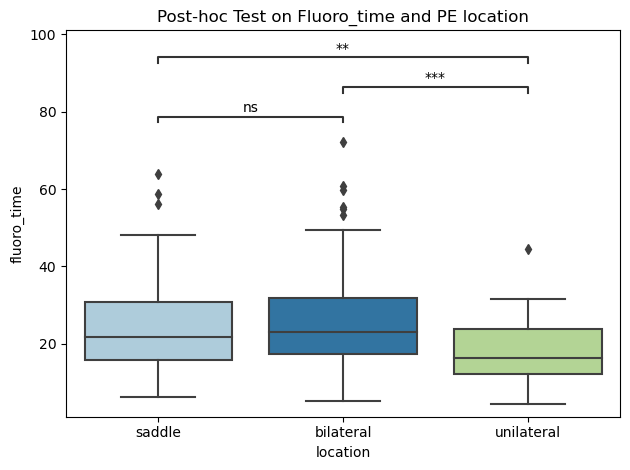

In [73]:
ax = sns.boxplot(data=df, x="location", y="fluoro_time",order=['saddle','bilateral','unilateral'],palette = "Paired")

pairs = [(i[1]["index"], i[1]["variable"]) for i in df_ph_f.iterrows()]
p_values = [i[1]["value"] for i in df_ph_f.iterrows()]

annotator = Annotator(
    ax, pairs, data=df, x="location", y='fluoro_time', order=['saddle','bilateral','unilateral']
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.title('Post-hoc Test on Fluoro_time and PE location')
plt.tight_layout()

#### Test on oversampling data using Simple Random Sampling technique
465 patients

Since we have very imbalanced class ditribution in terms of PE location, we need a method to balance the class distribution. One way of oversampling is to generate new samples for the minority class by sampling with replacement and then add them to the dataset.

In [74]:
# use simple random sampling to oversample the data
ros = RandomOverSampler(random_state=42)
X, y = df[['proc_time','cath_time','fluoro_time']], df['location']
X_ros, y_ros= ros.fit_resample(X, y)  # use ros to resample the dataset features and target
df_ros = pd.concat([X_ros, y_ros], axis=1)  # concatenate features and target to df_ros
df_ros = df_ros.sample(frac=1).reset_index(drop=True)  # shuffle the entire dataframe

In [75]:
df_ros.shape

(465, 4)

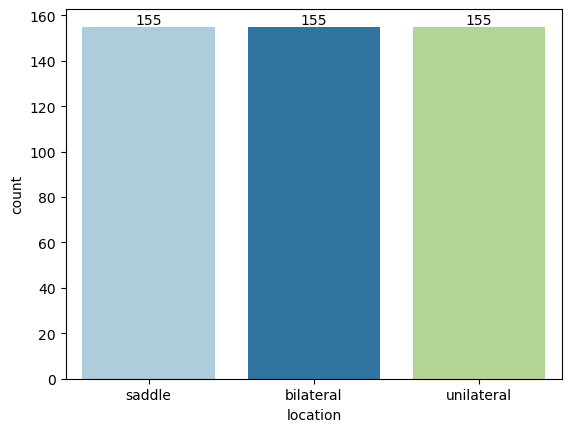

In [76]:
# obtain a balanced dataset in terms of location variable
ax = sns.countplot(data = df_ros, x ='location',order = ['saddle','bilateral','unilateral'],palette = "Paired")
ax.bar_label(ax.containers[0]);

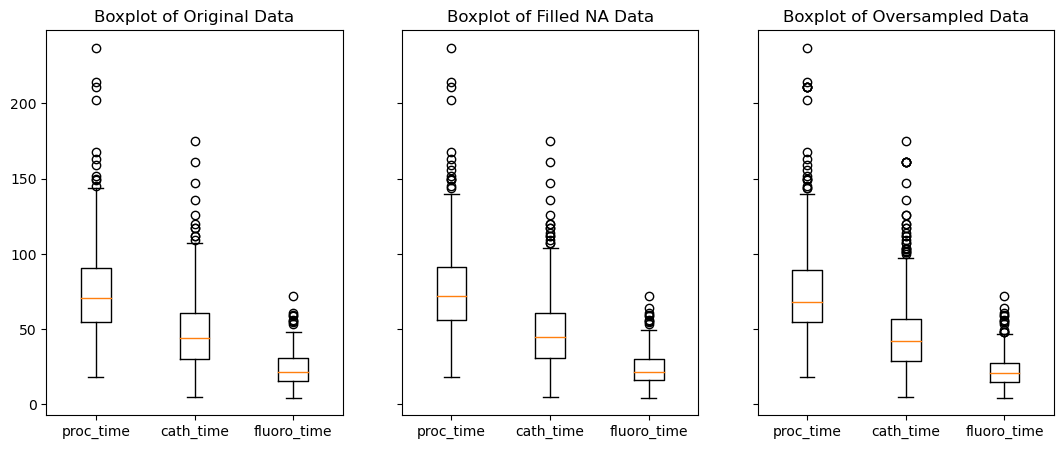

In [77]:
# distribution is similar
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True)
axes[0].boxplot(df_drop_na[['proc_time','cath_time','fluoro_time']])
axes[0].set_title('Boxplot of Original Data')
axes[0].set_xticks([1, 2, 3], ['proc_time', 'cath_time', 'fluoro_time'])
axes[1].boxplot(df[['proc_time','cath_time','fluoro_time']])
axes[1].set_title('Boxplot of Filled NA Data')
axes[1].set_xticks([1, 2, 3], ['proc_time', 'cath_time', 'fluoro_time'])
axes[2].boxplot(df_ros[['proc_time','cath_time','fluoro_time']])
axes[2].set_title('Boxplot of Oversampled Data')
axes[2].set_xticks([1, 2, 3], ['proc_time', 'cath_time', 'fluoro_time']);

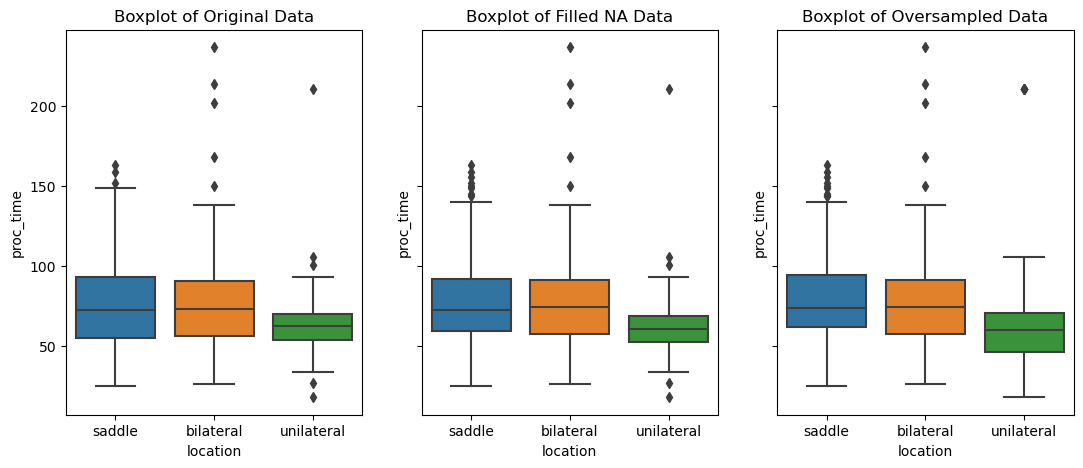

In [78]:
# distribution is similar in proc_time
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True)
sns.boxplot(y=df_drop_na['proc_time'],x=df_drop_na['location'],ax=axes[0])
axes[0].set_title('Boxplot of Original Data')

sns.boxplot(y=df['proc_time'],x=df['location'],ax=axes[1])
axes[1].set_title('Boxplot of Filled NA Data')

sns.boxplot(y=df_ros['proc_time'],x=df_ros['location'],ax=axes[2],order=['saddle','bilateral','unilateral'])
axes[2].set_title('Boxplot of Oversampled Data');

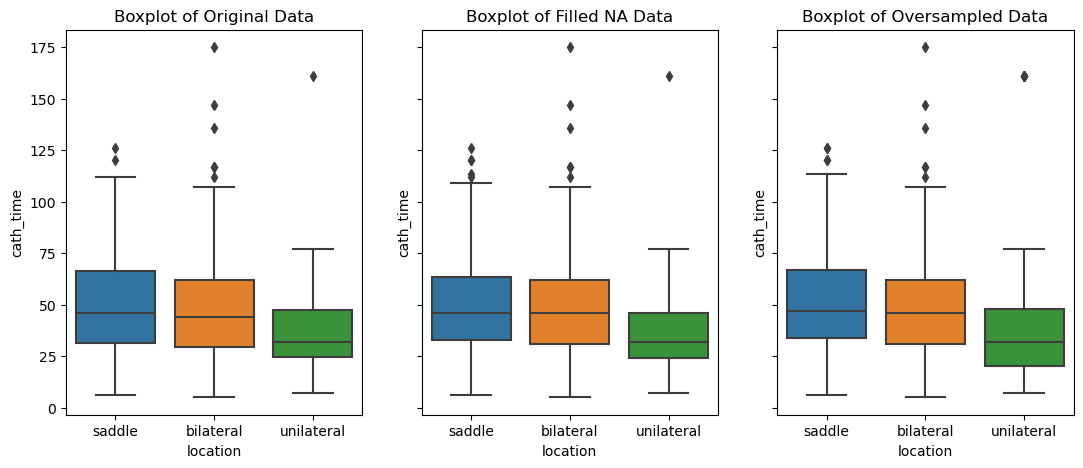

In [79]:
# distribution is similar in cath_time
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True)
sns.boxplot(y=df_drop_na['cath_time'],x=df_drop_na['location'],ax=axes[0])
axes[0].set_title('Boxplot of Original Data')

sns.boxplot(y=df['cath_time'],x=df['location'],ax=axes[1])
axes[1].set_title('Boxplot of Filled NA Data')

sns.boxplot(y=df_ros['cath_time'],x=df_ros['location'],ax=axes[2],order=['saddle','bilateral','unilateral'])
axes[2].set_title('Boxplot of Oversampled Data');

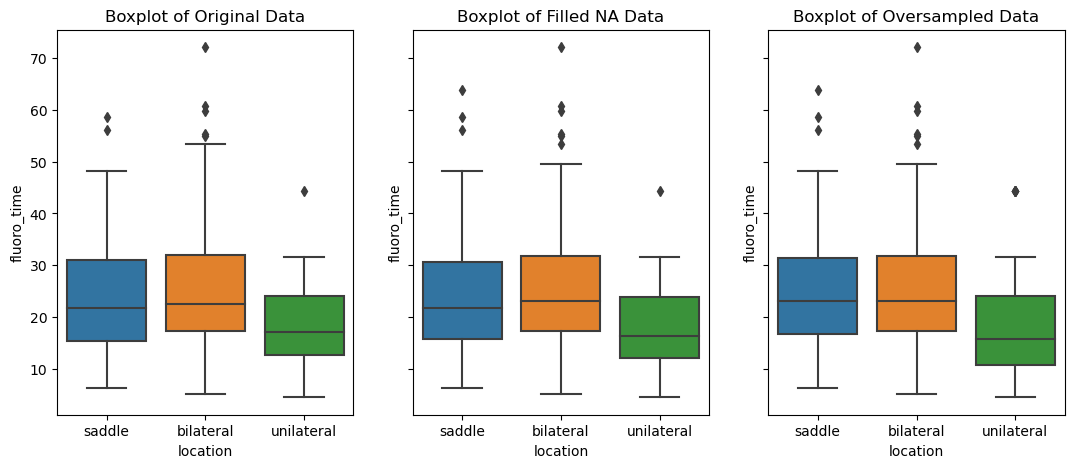

In [80]:
# distribution is similar in fluoro_time
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True)
sns.boxplot(y=df_drop_na['fluoro_time'],x=df_drop_na['location'],ax=axes[0])
axes[0].set_title('Boxplot of Original Data')

sns.boxplot(y=df['fluoro_time'],x=df['location'],ax=axes[1])
axes[1].set_title('Boxplot of Filled NA Data')

sns.boxplot(y=df_ros['fluoro_time'],x=df_ros['location'],ax=axes[2],order=['saddle','bilateral','unilateral'])
axes[2].set_title('Boxplot of Oversampled Data');

In [81]:
# Normality Assumption Check Fails
for i in ['proc_time','cath_time','fluoro_time']:
    print(stats.shapiro(df_ros[i])) 

ShapiroResult(statistic=0.8984811305999756, pvalue=5.071772560829674e-17)
ShapiroResult(statistic=0.8965156078338623, pvalue=3.441056128097324e-17)
ShapiroResult(statistic=0.9498304128646851, pvalue=1.866157749164099e-11)


In [82]:
# homoscedasticity assumption holds
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_ros[df_ros['location']=='saddle'][i]
    group2 = df_ros[df_ros['location']=='unilateral'][i]
    group3 = df_ros[df_ros['location']=='bilateral'][i]
    print(stats.levene(group1, group2, group3, center='median'))
# All p-values > 0.05 -> fail to reject null -> all groups have equal variances

LeveneResult(statistic=0.2765206801420625, pvalue=0.7585433676464866)
LeveneResult(statistic=0.8019600182187009, pvalue=0.4490724013048336)
LeveneResult(statistic=1.8503921007522233, pvalue=0.1583384746616447)


In [83]:
# kruskal wallis test 
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_ros[df_ros['location']=='saddle'][i]
    group2 = df_ros[df_ros['location']=='unilateral'][i]
    group3 = df_ros[df_ros['location']=='bilateral'][i]
    print(stats.kruskal(group1,group2,group3))

KruskalResult(statistic=30.50826492436997, pvalue=2.372544929101786e-07)
KruskalResult(statistic=37.36046773210151, pvalue=7.713962287191791e-09)
KruskalResult(statistic=60.2363574571889, pvalue=8.314596405326915e-14)


In [84]:
# post-hoc test on proc_time
group1 = df_ros[df_ros['location']=='saddle']['proc_time']
group2 = df_ros[df_ros['location']=='unilateral']['proc_time']
group3 = df_ros[df_ros['location']=='bilateral']['proc_time']
data = [group1, group2, group3]
df_ros_ph_p = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
df_ros_ph_p = df_ros_ph_p.rename(columns ={1:'saddle',2:'unilateral',3:'bilateral'},
                         index={1:'saddle',2:'unilateral',3:'bilateral'})
df_ros_ph_p
# saddle and unilateral location significantly differs in proc time
# bilateral and unilateral location significantly differs in proc time

,saddle,unilateral,bilateral
saddle,1.000000,0.000002,1.000000
unilateral,0.000002,1.000000,0.000013
bilateral,1.000000,0.000013,1.000000


In [85]:
df_ros_ph_p= df_ros_ph_p.melt(ignore_index=False).reset_index()
df_ros_ph_p = df_ros_ph_p[df_ros_ph_p['value']!=1]
df_ros_ph_p = df_ros_ph_p.drop_duplicates(subset='value')
df_ros_ph_p

,index,variable,value
1,unilateral,saddle,0.000002
5,bilateral,unilateral,0.000013


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bilateral vs. unilateral: Custom statistical test, P_val:1.291e-05
saddle vs. unilateral: Custom statistical test, P_val:2.216e-06


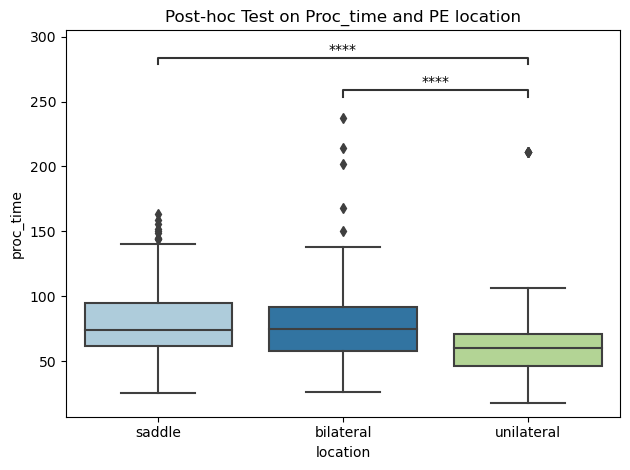

In [86]:
ax = sns.boxplot(data=df_ros, x="location", y="proc_time",order=['saddle','bilateral','unilateral'],palette = "Paired")

pairs = [(i[1]["index"], i[1]["variable"]) for i in df_ros_ph_p.iterrows()]
p_values = [i[1]["value"] for i in df_ros_ph_p.iterrows()]

annotator = Annotator(
    ax, pairs, data=df_ros, x="location", y='proc_time', order=['saddle','bilateral','unilateral']
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.title('Post-hoc Test on Proc_time and PE location')
plt.tight_layout()

In [87]:
# post-hoc test on cath_time
group1 = df_ros[df_ros['location']=='saddle']['cath_time']
group2 = df_ros[df_ros['location']=='unilateral']['cath_time']
group3 = df_ros[df_ros['location']=='bilateral']['cath_time']
data = [group1, group2, group3]
df_ros_ph_c = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
df_ros_ph_c = df_ros_ph_c.rename(columns ={1:'saddle',2:'unilateral',3:'bilateral'},
                         index={1:'saddle',2:'unilateral',3:'bilateral'})
df_ros_ph_c
# saddle and unilateral location significantly differs in cath time
# bilateral and unilateral location significantly differs in cath time

,saddle,unilateral,bilateral
saddle,1.000000e+00,4.849336e-08,1.000000
unilateral,4.849336e-08,1.000000e+00,0.000004
bilateral,1.000000e+00,3.768555e-06,1.000000


In [88]:
df_ros_ph_c= df_ros_ph_c.melt(ignore_index=False).reset_index()
df_ros_ph_c = df_ros_ph_c[df_ros_ph_c['value']!=1]
df_ros_ph_c = df_ros_ph_c.drop_duplicates(subset='value')
df_ros_ph_c

,index,variable,value
1,unilateral,saddle,4.849336e-08
5,bilateral,unilateral,3.768555e-06


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bilateral vs. unilateral: Custom statistical test, P_val:3.769e-06
saddle vs. unilateral: Custom statistical test, P_val:4.849e-08


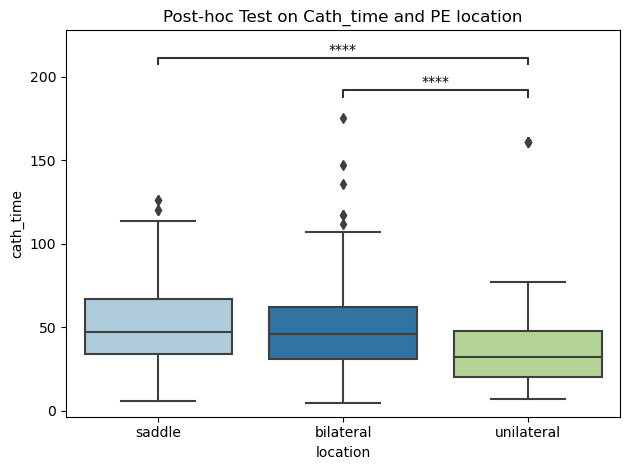

In [89]:
ax = sns.boxplot(data=df_ros, x="location", y="cath_time",order=['saddle','bilateral','unilateral'],palette = "Paired")

pairs = [(i[1]["index"], i[1]["variable"]) for i in df_ros_ph_c.iterrows()]
p_values = [i[1]["value"] for i in df_ros_ph_c.iterrows()]

annotator = Annotator(
    ax, pairs, data=df_ros, x="location", y='cath_time', order=['saddle','bilateral','unilateral']
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.title('Post-hoc Test on Cath_time and PE location')
plt.tight_layout()

In [90]:
# post-hoc test on fluoro_time
group1 = df_ros[df_ros['location']=='saddle']['fluoro_time']
group2 = df_ros[df_ros['location']=='unilateral']['fluoro_time']
group3 = df_ros[df_ros['location']=='bilateral']['fluoro_time']
data = [group1, group2, group3]
df_ros_ph_f = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
df_ros_ph_f = df_ros_ph_f.rename(columns ={1:'saddle',2:'unilateral',3:'bilateral'},
                         index={1:'saddle',2:'unilateral',3:'bilateral'})
df_ros_ph_f
# saddle and unilateral location significantly differs in fluoro time
# bilateral and unilateral location significantly differs in fluoro time

,saddle,unilateral,bilateral
saddle,1.000000e+00,2.230222e-10,1.000000e+00
unilateral,2.230222e-10,1.000000e+00,1.421767e-11
bilateral,1.000000e+00,1.421767e-11,1.000000e+00


In [91]:
df_ros_ph_f= df_ros_ph_f.melt(ignore_index=False).reset_index()
df_ros_ph_f = df_ros_ph_f[df_ros_ph_f['value']!=1]
df_ros_ph_f = df_ros_ph_f.drop_duplicates(subset='value')
df_ros_ph_f

,index,variable,value
1,unilateral,saddle,2.230222e-10
5,bilateral,unilateral,1.421767e-11


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bilateral vs. unilateral: Custom statistical test, P_val:1.422e-11
saddle vs. unilateral: Custom statistical test, P_val:2.230e-10


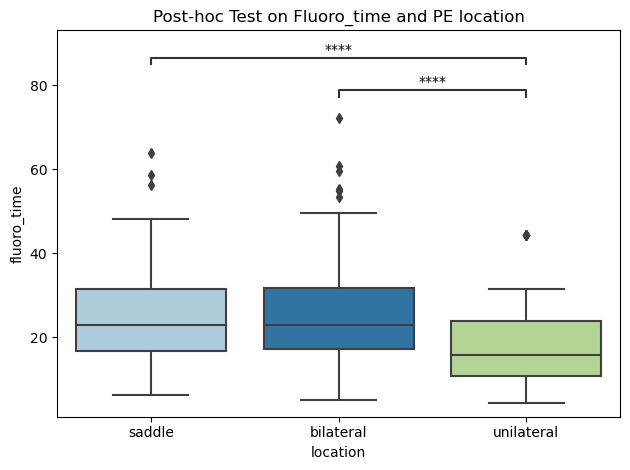

In [92]:
ax = sns.boxplot(data=df_ros, x="location", y="fluoro_time",order=['saddle','bilateral','unilateral'],palette = "Paired")

pairs = [(i[1]["index"], i[1]["variable"]) for i in df_ros_ph_f.iterrows()]
p_values = [i[1]["value"] for i in df_ros_ph_f.iterrows()]

annotator = Annotator(
    ax, pairs, data=df_ros, x="location", y='fluoro_time', order=['saddle','bilateral','unilateral']
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.title('Post-hoc Test on Fluoro_time and PE location')
plt.tight_layout()

As the dataset includes more patients(rows), the kruskal-wallis test becomes more significant. 

In origianl data without filling missing value (286 patients), location is making a difference in cath_time and fluoro_time. Based on the post-hoc test, saddle and unilateral have different medians in cath_time and saddle and unilateral & bilateral and unilateral have different medians in fluoro_time. 

In the dataset after filling missing value (318 patients), location is making a difference in proc_time, cath_time, and fluoro_time. Based on the post-hoc test, saddle and unilateral have different medians in proc_time, cath_time, and fluoro_time; bilateral and unilateral have different medians in proc_time, cath_time, and fluoro_time. 

In the dataset after smote oversampling (465 patients), location is again making a difference in proc_time, cath_time, and fluoro_time. Based on the post-hoc test, saddle and unilateral have different distributions in proc_time, cath_time, and fluoro_time; bilateral and unilateral have different distributions in proc_time, cath_time, and fluoro_time. This time, all the tests show a higher significance level compared to the previous dataset. 

In can be inferred from the result that with more data obtained, PE location plays a role in determining proc_time, cath_time, and fluoro_time. More speficially on the pairwise comparison, saddle and unilateral & bilateral and unilateral are having different medians, which are statistically significant. All the tests don't show saddle and bilateral are having different medians or different distributions. It can be implied that saddle and bilateral have very similar procedure time characteristics. This may due to the fact that saddle and bilateral are conditions where embolus lodged at the bifurcation of the pulmonary arteries or located in both left and right arteries and therefore may take more time. Future work can study on the similarity between procedure on saddle and bilateral PE location. 

#### The rest of the work is not included in the presentation and only serves as a reference for the discovery work I have done so far

### Disks & Procedure Time Variables Analysis

In [93]:
df_drop_na['missing'].value_counts()

0    176
1    110
Name: missing, dtype: int64

In [94]:
df_drop_namissing = df_drop_na[df_drop_na['missing'] == 0]
df_drop_namissing = df_drop_namissing.drop('missing',axis=1)
df_drop_namissing.shape

(176, 19)

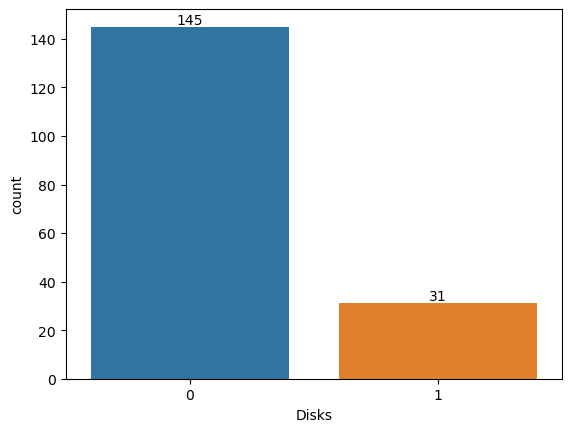

In [95]:
ax = sns.countplot(data = df_drop_namissing, x ='Disks')
ax.bar_label(ax.containers[0]);

In [96]:
# Normality Assumption Check
for i in ['proc_time','cath_time','fluoro_time']:
    print(stats.shapiro(df_drop_namissing[i])) 

ShapiroResult(statistic=0.8999313712120056, pvalue=1.552601935905784e-09)
ShapiroResult(statistic=0.9006410241127014, pvalue=1.7139948349509382e-09)
ShapiroResult(statistic=0.9269835352897644, pvalue=9.674709389173586e-08)


In [97]:
# homoscedasticity assumption fails
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_drop_namissing[df_drop_namissing['Disks']==1][i]
    group2 = df_drop_namissing[df_drop_namissing['Disks']==0][i]
    print(stats.levene(group1, group2, center='median'))

LeveneResult(statistic=17.038071282733362, pvalue=5.674327698219081e-05)
LeveneResult(statistic=27.788283298970693, pvalue=3.9729428429579773e-07)
LeveneResult(statistic=4.8353028234978845, pvalue=0.029201687729325528)


In [98]:
# kruskal wallis test (non-parametric alternative to one-way anova test)
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_drop_namissing[df_drop_namissing['Disks']==1][i]
    group2 = df_drop_namissing[df_drop_namissing['Disks']==0][i]
    print(stats.kruskal(group1,group2))

KruskalResult(statistic=12.12650577219486, pvalue=0.0004971017621219849)
KruskalResult(statistic=13.317785201181236, pvalue=0.00026290052583256623)
KruskalResult(statistic=9.294963977725129, pvalue=0.002297846593951616)


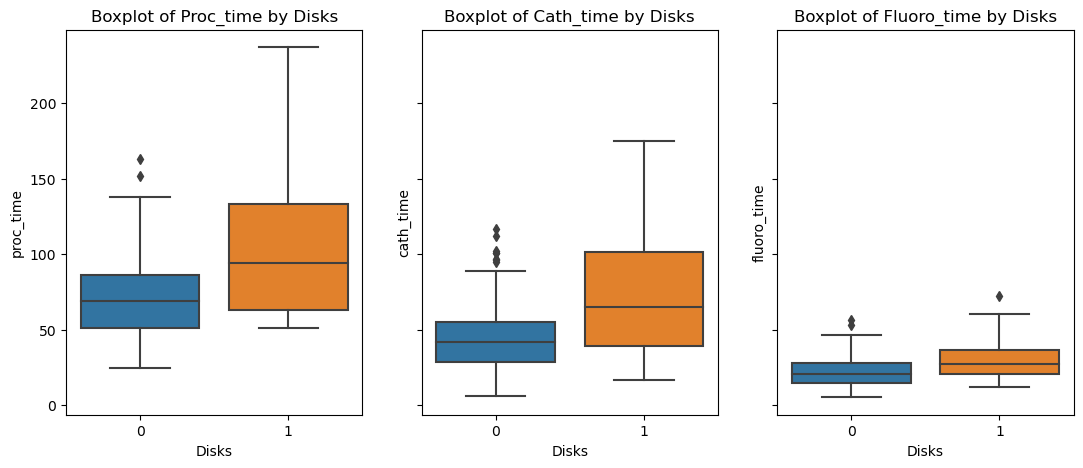

In [99]:
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True)
sns.boxplot(y=df_drop_namissing['proc_time'],x=df_drop_namissing['Disks'],ax=axes[0])
axes[0].set_title('Boxplot of Proc_time by Disks')

sns.boxplot(y=df_drop_namissing['cath_time'],x=df_drop_namissing['Disks'],ax=axes[1])
axes[1].set_title('Boxplot of Cath_time by Disks')

sns.boxplot(y=df_drop_namissing['fluoro_time'],x=df_drop_namissing['Disks'],ax=axes[2])
axes[2].set_title('Boxplot of Fluoro_time by Disks');

In [100]:
df['missing'].value_counts()

0    196
1    123
Name: missing, dtype: int64

In [101]:
df_drop_missing = df[df['missing'] == 0]
df_drop_missing = df_drop_missing.drop('missing',axis=1)
df_drop_missing.shape

(196, 19)

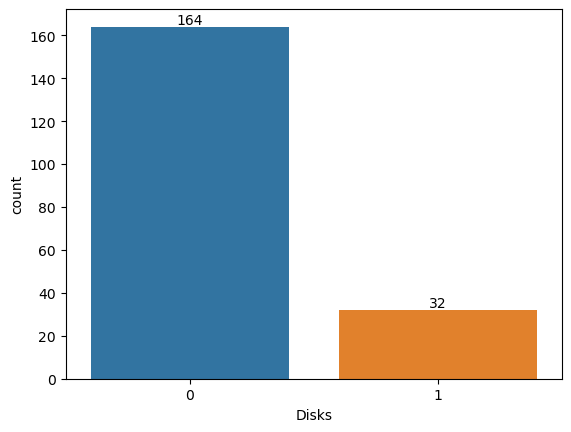

In [102]:
ax = sns.countplot(data = df_drop_missing, x ='Disks')
ax.bar_label(ax.containers[0]);

In [103]:
# Normality Assumption Check
for i in ['proc_time','cath_time','fluoro_time']:
    print(stats.shapiro(df_drop_missing[i])) 

ShapiroResult(statistic=0.9027090668678284, pvalue=5.031462468885195e-10)
ShapiroResult(statistic=0.904220700263977, pvalue=6.299988308811066e-10)
ShapiroResult(statistic=0.9209141135215759, pvalue=8.894892822297606e-09)


In [104]:
# homoscedasticity assumption fails
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_drop_missing[df_drop_missing['Disks']==1][i]
    group2 = df_drop_missing[df_drop_missing['Disks']==0][i]
    print(stats.levene(group1, group2, center='median'))

LeveneResult(statistic=15.501350458270936, pvalue=0.00011487336473486445)
LeveneResult(statistic=25.33897335906044, pvalue=1.0942184005618925e-06)
LeveneResult(statistic=3.74750881133606, pvalue=0.054339664815155404)


In [105]:
# Kruskal_wallis Test
for i in ['proc_time','cath_time','fluoro_time']:
    group1 = df_drop_missing[df_drop_missing['Disks']==1][i]
    group2 = df_drop_missing[df_drop_missing['Disks']==0][i]    
    print(stats.kruskal(group1,group2))

KruskalResult(statistic=12.497467371841886, pvalue=0.00040750407325968515)
KruskalResult(statistic=13.355052366401337, pvalue=0.0002577273457070033)
KruskalResult(statistic=9.931876443187026, pvalue=0.0016244085248335212)


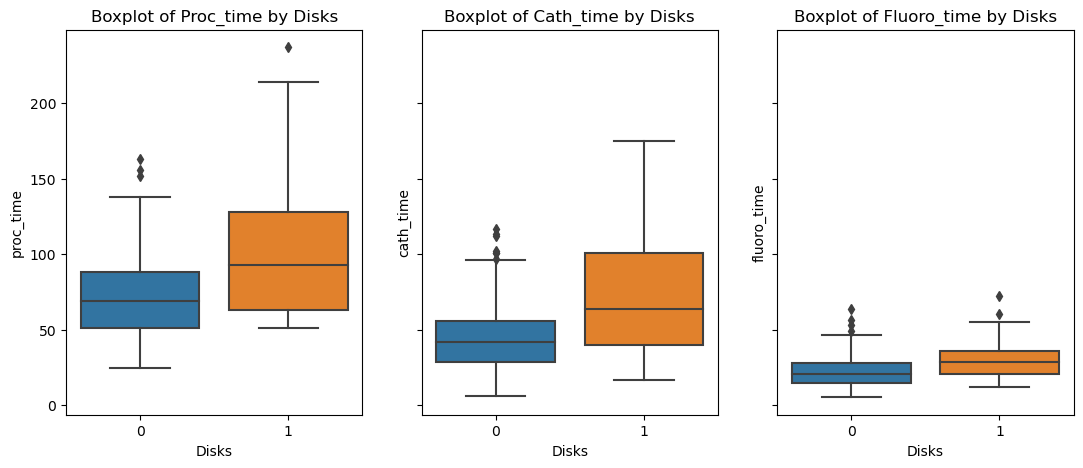

In [106]:
fig, axes = plt.subplots(1,3,figsize=(13,5),sharey=True)
sns.boxplot(y=df_drop_missing['proc_time'],x=df_drop_missing['Disks'],ax=axes[0])
axes[0].set_title('Boxplot of Proc_time by Disks')

sns.boxplot(y=df_drop_missing['cath_time'],x=df_drop_missing['Disks'],ax=axes[1])
axes[1].set_title('Boxplot of Cath_time by Disks')

sns.boxplot(y=df_drop_missing['fluoro_time'],x=df_drop_missing['Disks'],ax=axes[2])
axes[2].set_title('Boxplot of Fluoro_time by Disks');

## Location & Procedure Type Analysis

In [107]:
def function(a,b):
    if (a == 1) & (b == 0):
        return 'T20'
    elif (a == 0) & (b == 0):
        return 'T24'
    elif (a == 1) & (b == 1):
        return 'T20+Disks'
    elif (a == 0) & (b == 1):
        return 'T24+Disks'

In [108]:
df_drop_missing['Procedure Type'] = df_drop_missing.apply(lambda x: function(x['T20'],x['Disks']),axis=1)
df_drop_missing.head()

,PATIENTID,site,age,bmi,CUPE,location,spesi,rvlv_rat,biomarkers,dyspnea,lytics_contra,hx_pe,hx_dvt,cur_dvt,proc_time,cath_time,fluoro_time,T20,Disks,Procedure Type
0,watwnk53tw,5,65.051335,36.54,Submassive (Intermediate Risk),saddle,2.0,1.300000,Yes,3,No,No,No,Yes,82.0,60.0,34.55,1,0,T20
3,1uw7qeu5gb,19,72.736482,25.96,Massive (High Risk),saddle,1.0,1.438999,Yes,Not done,No,No,No,No,67.3,47.0,19.50,0,0,T24
4,xq1rhscbk3,27,69.399042,41.45,Massive (High Risk),bilateral,2.0,1.864238,Yes,4,No,No,No,No,62.0,37.0,12.80,0,0,T24
6,al57aa2lwj,10,69.886379,40.09,Submassive (Intermediate Risk),bilateral,1.0,2.230189,Yes,<undefined>,No,No,No,Yes,108.0,96.0,33.00,1,0,T20
7,hnhny03b9m,11,68.317591,34.70,Submassive (Intermediate Risk),saddle,0.0,1.921933,Yes,4,No,Yes,Yes,Yes,149.0,100.0,42.20,1,1,T20+Disks


In [109]:
CrosstabResult1=pd.crosstab(index=df_drop_missing['location'],columns=df_drop_missing['Procedure Type'])
print(CrosstabResult1)

Procedure Type  T20  T20+Disks  T24  T24+Disks
location                                      
bilateral        53         14   21          3
saddle           47         11   26          2
unilateral       12          2    5          0


In [110]:
ChiSqResult1 = chi2_contingency(CrosstabResult1)
print('The P-Value of the ChiSq Test is:', ChiSqResult1[1])

The P-Value of the ChiSq Test is: 0.9040099992368855


In [111]:
CrosstabResult2=pd.crosstab(index=df_drop_missing['location'],columns=df_drop_missing['T20'])
print(CrosstabResult2)

T20          0   1
location          
bilateral   24  67
saddle      28  58
unilateral   5  14


In [112]:
ChiSqResult2 = chi2_contingency(CrosstabResult2)
print('The P-Value of the ChiSq Test is:', ChiSqResult2[1])

The P-Value of the ChiSq Test is: 0.6382618069525707


In [113]:
CrosstabResult3=pd.crosstab(index=df_drop_missing['location'],columns=df_drop_missing['Disks'])
print(CrosstabResult3)

Disks        0   1
location          
bilateral   74  17
saddle      73  13
unilateral  17   2


In [114]:
ChiSqResult3 = chi2_contingency(CrosstabResult3)
print('The P-Value of the ChiSq Test is:', ChiSqResult3[1])

The P-Value of the ChiSq Test is: 0.6282962612709415


In [115]:
df_drop_missing = df_drop_missing[df_drop_missing['location']!='saddle']

In [116]:
CrosstabResult1=pd.crosstab(index=df_drop_missing['location'],columns=df_drop_missing['T20'])
print(CrosstabResult1)

T20          0   1
location          
bilateral   24  67
unilateral   5  14


In [117]:
print(stats.fisher_exact(CrosstabResult1))

(1.0029850746268656, 1.0)


In [118]:
CrosstabResult2=pd.crosstab(index=df_drop_missing['location'],columns=df_drop_missing['Disks'])
print(CrosstabResult2)

Disks        0   1
location          
bilateral   74  17
unilateral  17   2


In [119]:
print(stats.fisher_exact(CrosstabResult2))

(0.5121107266435986, 0.5185643530525647)


In [120]:
ChiSqResult1 = chi2_contingency(CrosstabResult1)
print('The P-Value of the ChiSq Test is:', ChiSqResult1[1])
# variables are not correlated

The P-Value of the ChiSq Test is: 1.0


In [121]:
CrosstabResult2=pd.crosstab(index=df_drop_missing['location'],columns=df_drop_missing['T20'])
print(CrosstabResult2)

T20          0   1
location          
bilateral   24  67
unilateral   5  14


In [122]:
ChiSqResult2 = chi2_contingency(CrosstabResult2)
print('The P-Value of the ChiSq Test is:', ChiSqResult2[1])
# variables are not correlated

The P-Value of the ChiSq Test is: 1.0
